In [5]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

import category_encoders as ce
import lightgbm as lgb
import shap
import re

plt.style.use('seaborn')

In [6]:
def preprocess_dataset(data, numerical_features):
    """Apply data preprocessing such as imputation and one-hot-encoding"""
    df = data.copy()

    # Convert to int
    df["has_paid"] = df["has_paid"].astype(int)

    # Bin numerical features
    df, new_features = _bin_features(df)

    # Encode data
    encoder = ce.one_hot.OneHotEncoder(
        cols=encoded_features,
        use_cat_names=True,
        handle_unknown="indicator",
        handle_missing="indicator"
    )
    df = encoder.fit_transform(df)

    # Rename invalid column names
    df = df.rename(columns=lambda x: re.sub('[^A-Za-z0-9_]+', '', x))

    # Impute nulls
    target_features = [
        "account_status",
        "account_worst_status_12_24m",
        "account_worst_status_6_12m",
        "account_worst_status_3_6m",
        "account_worst_status_0_3m"
    ]
    df.loc[:, target_features] = df[target_features].fillna(0)

    numerical_features = numerical_features + new_features
    features = list(set(df.columns.to_list()) - {"uuid", "default"})
    categorical_features = list(set(features) - set(numerical_features))
    return df, features, categorical_features


def _bin_features(df):
    def _bin(column, df):
        df[f"{column}_bin"], bins = pd.qcut(df[column], q=10, labels=False, retbins=True, duplicates="drop")
        return df, f"{column}_bin"
   
    new_features = []
    
    for f in binned_features:
        df, new_f = _bin(f, df)
        new_features.append(new_f)

    return df, new_features

In [13]:

binned_features = [
    "time_hours",
    "age",
    "max_paid_inv_0_24m",
    "avg_payment_span_0_3m",
    "num_arch_ok_0_12m",
    "num_arch_ok_12_24m"
]

numerical_features = [
    "account_amount_added_12_24m",
    "account_days_in_dc_12_24m",
    "account_days_in_rem_12_24m",
    "account_days_in_term_12_24m",
    "account_incoming_debt_vs_paid_0_24m",
    "age",
    "avg_payment_span_0_12m",
    "avg_payment_span_0_3m",
    "max_paid_inv_0_12m",
    "max_paid_inv_0_24m",
    "num_active_div_by_paid_inv_0_12m",
    "num_active_inv",
    "num_arch_dc_0_12m",
    "num_arch_dc_12_24m",
    "num_arch_ok_0_12m",
    "num_arch_ok_12_24m",
    "num_arch_rem_0_12m",
    "num_arch_written_off_0_12m",
    "num_arch_written_off_12_24m",
    "num_unpaid_bills",
    "recovery_debt",
    "sum_capital_paid_account_0_12m",
    "sum_capital_paid_account_12_24m",
    "sum_paid_inv_0_12m",
    "time_hours",
]

categorical_features = [
    "account_status",
    "account_worst_status_0_3m",
    "account_worst_status_12_24m",
    "account_worst_status_3_6m",
    "account_worst_status_6_12m",
    "merchant_category",
    "merchant_group",
    "has_paid",
    "name_in_email",
    "status_last_archived_0_24m",
    "status_2nd_last_archived_0_24m",
    "status_3rd_last_archived_0_24m",
    "status_max_archived_0_6_months",
    "status_max_archived_0_12_months",
    "status_max_archived_0_24_months",
    "worst_status_active_inv",
]


collinear_features = [
    "status_last_archived_0_24m",
    "status_max_archived_0_12_months",
    "status_max_archived_0_24_months",
    "sum_capital_paid_account_0_12m",
    "sum_capital_paid_account_12_24m",
    "sum_paid_inv_0_12m"
]


low_correlation_features = [
    'account_amount_added_12_24m',
    'account_days_in_dc_12_24m',
    'account_days_in_rem_12_24m',
    'account_days_in_term_12_24m',
    'account_incoming_debt_vs_paid_0_24m'
]


encoded_features = [
    "merchant_category",
    "merchant_group",
    "name_in_email",
]

# numerical_features = list(set(numerical_features) - set(collinear_features) - set(low_correlation_features))
# features = categorical_features + numerical_features
# target = "default"

def bin_and_drop(column, df):
    df[f"{column}_bin"], bins = pd.qcut(df[column], q=10, labels=False, retbins=True, duplicates="drop")
#     numerical_features.remove(column)
    categorical_features.append(f"{column}_bin")
#     return df.drop(columns=[column])
    return df

# df_train = bin_and_drop("time_hours", df_train)
# df_train = bin_and_drop("age", df_train)
# df_train = bin_and_drop("max_paid_inv_0_24m", df_train)
# df_train = bin_and_drop("avg_payment_span_0_3m", df_train)
# df_train = bin_and_drop("avg_payment_span_summed", df_train)


df = pd.read_csv("dataset.csv", delimiter=";")
df["has_paid"] = df["has_paid"].astype(int)

df, features, categorical_features = preprocess_dataset(df, numerical_features)


df_train = df[~df.default.isnull()].copy()
df_test = df[df.default.isnull()].copy()
df_test.pop("default")
target = "default"



# df_train_encoded = pd.get_dummies(df_train, prefix=categorical_features, columns=categorical_features)
# df_train_encoded = df_train_encoded.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
train, validation = train_test_split(df_train, test_size=0.1, stratify=df_train[target], random_state=42)

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


In [11]:
total = df_train.isnull().sum().sort_values(ascending=False)
percent = (df_train.isnull().sum() / df_train.isnull().count() * 100).sort_values(ascending = False)
df_percent_nans = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
df_percent_nans.head(20)

,Total,Percent
worst_status_active_inv,62540,69.507424
account_incoming_debt_vs_paid_0_24m,53357,59.301369
avg_payment_span_0_3m_bin,44382,49.326487
avg_payment_span_0_3m,44382,49.326487
avg_payment_span_0_12m,21468,23.859696
num_active_div_by_paid_inv_0_12m,20658,22.959456
num_arch_written_off_0_12m,16305,18.121499
num_arch_written_off_12_24m,16305,18.121499
account_days_in_term_12_24m,10683,11.873166
account_days_in_rem_12_24m,10683,11.873166


In [132]:
target_features = [
    "account_status",
    "account_worst_status_12_24m",
    "account_worst_status_6_12m",
    "account_worst_status_3_6m",
    "account_worst_status_0_3m"
]
df_train[target_features] = df_train[target_features].fillna(0)




# target_features = [
#     "num_arch_written_off_0_12m",
#     "num_arch_written_off_12_24m",
# ]

# correlated_features = [
#     "status_max_archived_0_6_months",
#     "status_max_archived_0_12_months",
#     "status_max_archived_0_24_months",
# ]

# df_train[target_features] = df_train[target_features].fillna(0)




# target_features = [
#     "worst_status_active_inv"
# ]

# correlated_features = [
#     "num_active_inv",
# ]

# df_train[target_features] = df_train[target_features].fillna(0)





# target_features = [
#     "account_days_in_dc_12_24m",
#     "account_days_in_rem_12_24m",
#     "account_days_in_term_12_24m",
# ]

# correlated_features = [
#     "account_status",
#     "account_worst_status_0_3m",
#     "account_worst_status_12_24m",
#     "account_worst_status_3_6m",
#     "account_worst_status_6_12m",
# ]

# df_train[target_features] = df_train[target_features].fillna(0)







# target_features = [
#     "avg_payment_span_0_3m", # 49305 nulls
#     "avg_payment_span_0_12m" # 23836 nulls
# ]

# correlated_features = [
#     "status_max_archived_0_6_months",
#     "status_max_archived_0_12_months",
# ]

# new_imputed_features = [
#     "avg_payment_span_0_3m_mean_imp",
#     "avg_payment_span_0_12m_mean_imp",
#     "avg_payment_span_0_3m_median_imp",
#     "avg_payment_span_0_12m_median_imp"
# ]

# df_train[new_imputed_features[:2]] = df_train[target_features].fillna(df_train[target_features].mean())
# df_train[new_imputed_features[2:]] = df_train[target_features].fillna(df_train[target_features].median())
# df_train = df_train.drop(columns=target_features)

In [ ]:
%%time
# Copy the data
df_imputed = train[features].copy(deep=True)

# Init
ii_imp = IterativeImputer(
#     imputation_order="descending",
    initial_strategy="most_frequent",
    n_nearest_features=10,
    estimator=ExtraTreesRegressor(),
    max_iter=10,
    verbose=2,
    random_state=42
)

# Transform
df_imputed.loc[:,:] = ii_imp.fit_transform(df_imputed)
train.loc[:, features] = df_imputed.loc[:, features].values
validation.loc[:,features] = ii_imp.transform(validation[features])

In [ ]:
# from sklearn.utils import resample

# not_default = train[train.default==0].copy()
# default = train[train.default==1].copy()

# not_default_downsampled = resample(
#     not_default,
#     replace=False, # sample without replacement
#     n_samples=len(not_default), # match minority n
#     random_state=42
# )

# # combine minority and downsampled majority
# downsampled = pd.concat([not_default_downsampled, default])
# downsampled.default.value_counts()


# downsampled.default.value_counts()


# # upsample minority
# default_upsampled = resample(
#     default,
#     replace=True, # sample with replacement
#     n_samples=len(not_default), # match number in majority class
#     random_state=42
# )

# # combine majority and upsampled minority
# upsampled = pd.concat([not_default, default_upsampled])

# # check new class counts
# upsampled.default.value_counts()

# from imblearn.over_sampling import SMOTE

# smote = SMOTE()
# X_sm, y_sm = smote.fit_resample(train[features], train[target])

In [14]:
%%time
from sklearn.metrics import f1_score

def f1_score_valid(y_hat, lgb_data):
    y_true = lgb_data.get_label()
    y_hat = np.where(y_hat < 0.5, 0, 1)
    return 'f1', f1_score(y_true, y_hat), True

target = "default"
pos_examples = df_train.query(f"{target} == 1").shape[0]
neg_examples = df_train.query(f"{target} == 0").shape[0]

scale_pos_weight = neg_examples / pos_examples

hyperparams = {
    "boosting_type": "gbdt",
    "objective": "binary",
    "scale_pos_weight": np.sqrt(scale_pos_weight),
    "random_state": 1337,
    "verbose": -1,
    "num_iterations": 5000,
#     'max_depth' : 4,
    'nthread': 7,
#     'num_leaves': 64,
    'learning_rate': 0.01,
    "metric" : ["auc", "f1"],
    "early_stopping_rounds": 200,
    "first_metric_only": True
}



hyperparams = {
    "colsample_bytree": 0.3703179242747248,
    "first_metric_only": True,
    "learning_rate": 0.01,
    "max_depth": -1,
    "metric": ["auc", "f1"],
    "min_split_gain": 0.11729629759453758,
    "n_jobs": 8,
    "num_leaves": 40,
    "objective": "binary",
    "random_state": 1337,
    "reg_alpha": 0.0751820508685504,
    "reg_lambda": 4.734810118443678,
    "scale_pos_weight": 6.051149289825428,
    "subsample": 0.6970067926095256,
    "verbose": -1,
    "n_estimators": 2000,
    "early_stopping_rounds": 200,
}

lgb_train = lgb.Dataset(
    train[features],
    train[target],
    feature_name=features,
    categorical_feature=categorical_features
)

lgb_validation = lgb.Dataset(
    validation[features],
    validation[target],
    reference=lgb_train,
    feature_name=features,
    categorical_feature=categorical_features,
    free_raw_data=False
)

lgb_cv = lgb.Dataset(
    df_train[features],
    df_train[target],
    feature_name=features,
    categorical_feature=categorical_features,
)

evals_result = {}

lgb_model = lgb.train(
    hyperparams,
    lgb_train,
    valid_sets=[lgb_train, lgb_validation],
    valid_names=['train', 'val'],
    evals_result=evals_result,
    verbose_eval=100,
    feval=f1_score_valid
)


eval_hist = lgb.cv(
    hyperparams,
    lgb_cv,
    stratified=True,
    show_stdv=False,
    nfold=5,
    verbose_eval=100,
    seed=42,
    eval_train_metric=True,
    feval=f1_score_valid,
    return_cvbooster=True,
)

Found `n_estimators` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Using categorical_feature in Dataset.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


Training until validation scores don't improve for 200 rounds
[100]	train's auc: 0.940451	train's f1: 0.0171086	val's auc: 0.912853	val's f1: 0.0152672
[200]	train's auc: 0.951113	train's f1: 0.333528	val's auc: 0.915673	val's f1: 0.125
[300]	train's auc: 0.958351	train's f1: 0.438186	val's auc: 0.91609	val's f1: 0.227488
[400]	train's auc: 0.963968	train's f1: 0.481531	val's auc: 0.916441	val's f1: 0.253275
[500]	train's auc: 0.968301	train's f1: 0.517749	val's auc: 0.916111	val's f1: 0.268398
Early stopping, best iteration is:
[338]	train's auc: 0.960623	train's f1: 0.457743	val's auc: 0.916689	val's f1: 0.243243
Evaluated only: auc
CPU times: user 2min 23s, sys: 1.28 s, total: 2min 25s
Wall time: 18.6 s


In [12]:
#[540]	train's auc: 0.969821	train's f1: 0.528825	val's auc: 0.916945	val's f1: 0.275862

# cv
# auc: 0.912265, f1: 0.283191

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


In [38]:
df_test["pd"] = lgb_model.predict(df_test[features])

df_test[["uuid","pd"]].to_csv("predictions.csv", index=False, sep=";")

In [34]:
9854/146

67.4931506849315

auc: 0.912265, f1: 0.283191


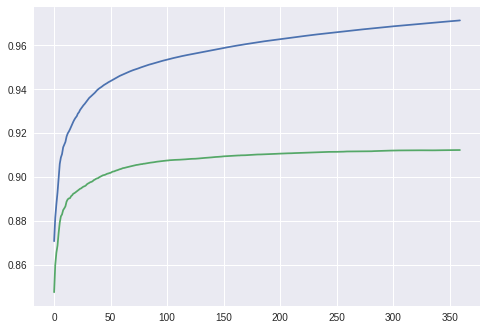

In [91]:
plt.plot(eval_hist['train auc-mean'])
plt.plot(eval_hist['valid auc-mean'])

print(f"auc: {np.round(np.max(eval_hist['valid auc-mean']), 6)}, f1: {np.round(np.max(eval_hist['valid f1-mean']), 6)}")

In [40]:
y_true = validation[target]
y_pred_prob = lgb_model.predict(lgb_validation.get_data())
y_pred =  np.where(y_pred_prob < 0.5, 0, 1)

f1_score(y_true, y_pred)

0.24324324324324326

<AxesSubplot:title={'center':'Metric during training'}, xlabel='Iterations', ylabel='auc'>

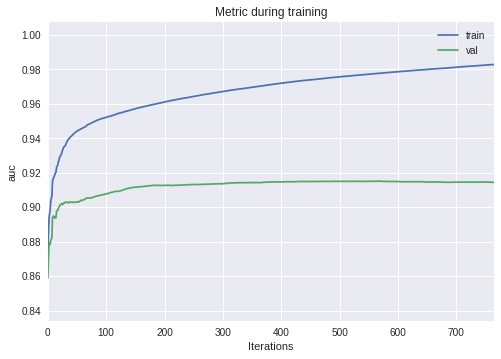

In [146]:
# lgb.plot_metric(evals_result, "f1")
# lgb.plot_metric(evals_result, "binary_logloss")
lgb.plot_metric(evals_result, "auc")

Overall accuracy of Light GBM model: 0.9813291842631696


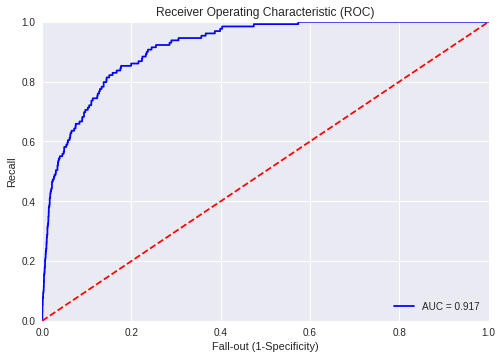

AUC score: 0.9166887363965244


<Figure size 576x396 with 0 Axes>

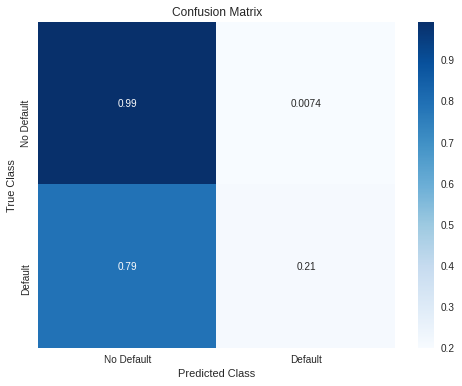

f1 score: 0.24324324324324326


In [47]:
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, auc

#Print accuracy
y_pred =  np.where(y_pred_prob < 0.5, 0, 1)
acc_lgbm = accuracy_score(y_true, y_pred)
print('Overall accuracy of Light GBM model:', acc_lgbm)

#Print Area Under Curve
plt.figure()
false_positive_rate, recall, thresholds = roc_curve(y_true, y_pred_prob)
roc_auc = auc(false_positive_rate, recall)
plt.title('Receiver Operating Characteristic (ROC)')
plt.plot(false_positive_rate, recall, 'b', label = 'AUC = %0.3f' %roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.ylabel('Recall')
plt.xlabel('Fall-out (1-Specificity)')
plt.show()

print('AUC score:', roc_auc)

#Print Confusion Matrix
plt.figure()
cm = confusion_matrix(y_true, y_pred, normalize="true")
labels = ['No Default', 'Default']
plt.figure(figsize=(8,6))
sns.heatmap(cm, xticklabels = labels, yticklabels = labels, annot = True, cmap="Blues", vmin = 0.2);
plt.title('Confusion Matrix')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()
print(f"f1 score: {f1_score(y_true, y_pred)}")

# SHAP Feature Importance

In [72]:
shap.initjs()

In [94]:
explainer = shap.TreeExplainer(lgb_model)
shap_values = explainer.shap_values(train[features])

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


## Shap Summary Plot

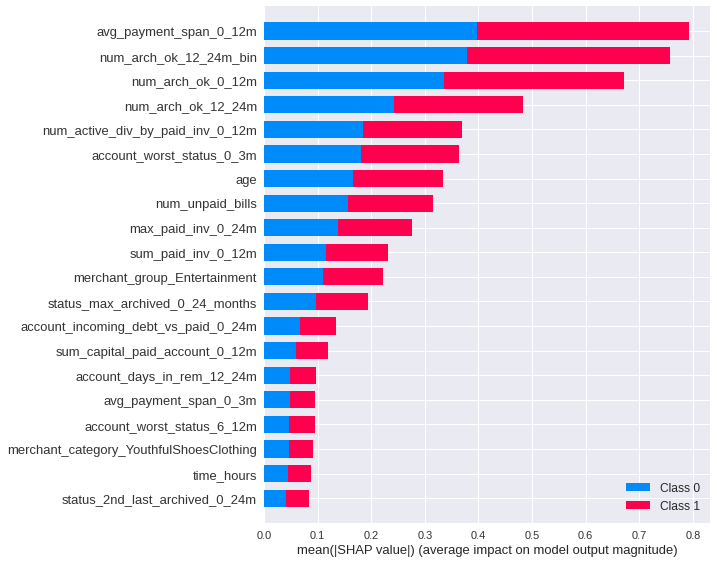

In [108]:
shap.summary_plot(shap_values, train[features], plot_type='bar')

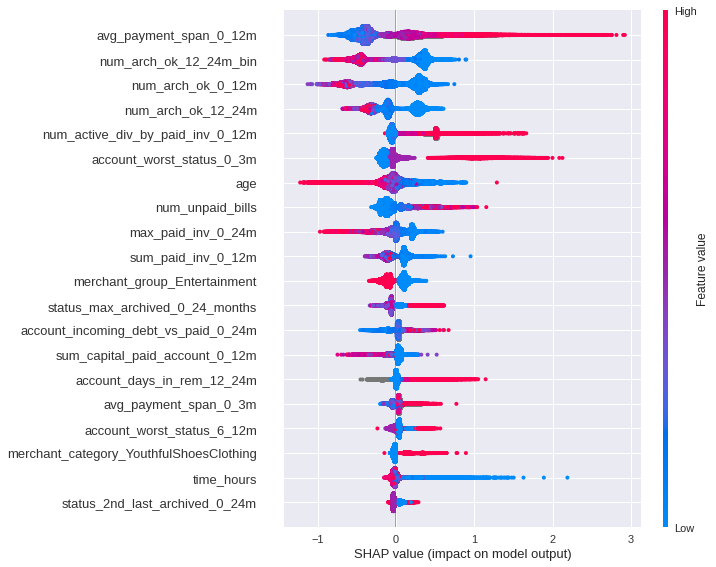

In [109]:
shap.summary_plot(shap_values[1], train[features], plot_type='dot')

## Shap Dependence Plots

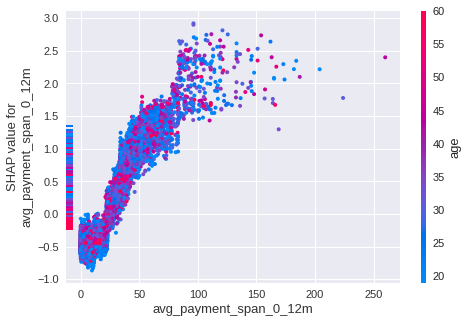

In [100]:
shap.dependence_plot("avg_payment_span_0_12m", shap_values[1], train[features])

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


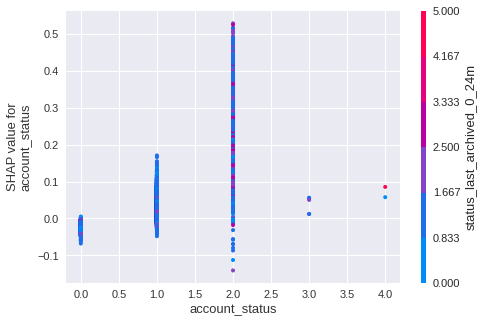

In [119]:
shap.dependence_plot("account_status", shap_values[1], train[features])

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


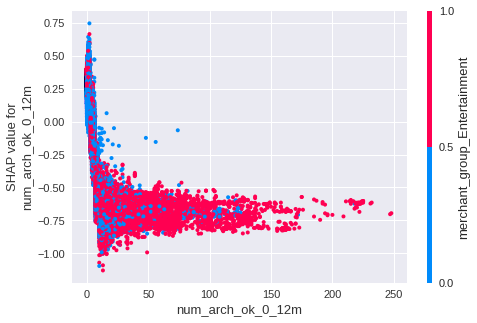

In [116]:
shap.dependence_plot("num_arch_ok_0_12m", shap_values[1], train[features])

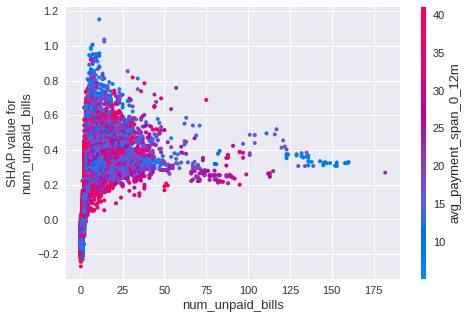

In [117]:
shap.dependence_plot("num_unpaid_bills", shap_values[1], train[features])